<a href="https://colab.research.google.com/github/njokinjuguna/Machine-learning-Models/blob/main/RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RandomForestClassifier**

### **Import Libraries**

In [11]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.simplefilter(action='ignore', category=Warning)

df = pd.read_csv(r'diabetes.csv')




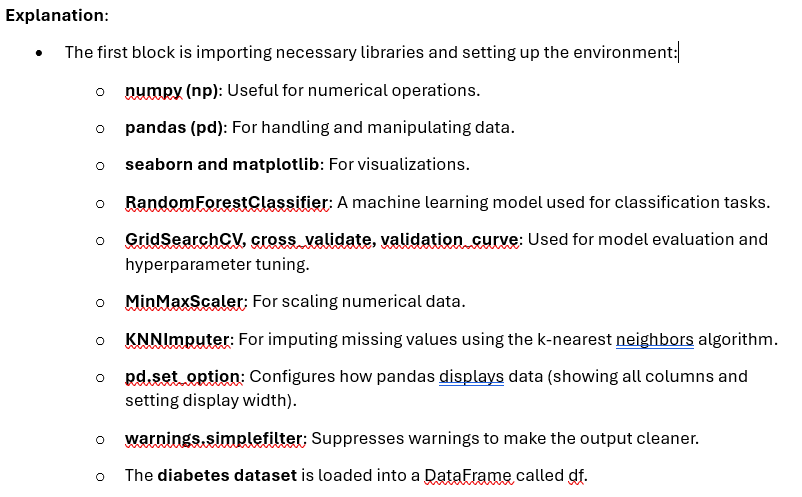

## **methods**

In [12]:
def outlier_thresholds(dataframe ,col ,q1=.05 , q3=.95, decimal=3):
    quartile1=dataframe[col].quantile(q1)
    quartile3=dataframe[col].quantile(q3)
    iqr=quartile3-quartile1
    low_limit= round(quartile1 - (iqr*1.5) , decimal)
    up_limit= round(quartile3 + (iqr*1.5), decimal)
    return low_limit , up_limit


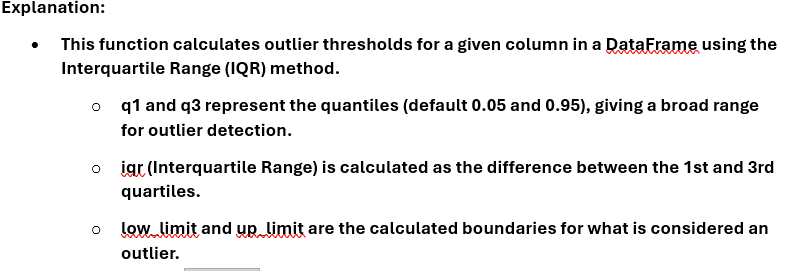

In [13]:
def replace_with_thresholds(dataframe, col_name, q1=.05, q3=.95, lower_limit = None, upper_limit = None):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if lower_limit != None:
        dataframe.loc[(dataframe[col_name] < lower_limit), col_name] = lower_limit
    else:
        dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit

    if upper_limit != None:
        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
    else:
        dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

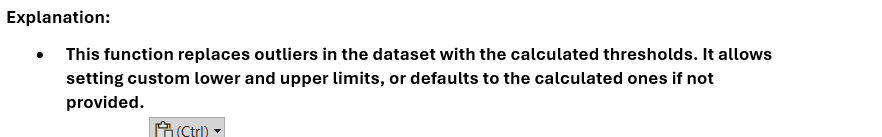

In [14]:
def plot_importance(model, features, num:int = 0, save=False):
    if num <= 0:
        num = X.shape[1]
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

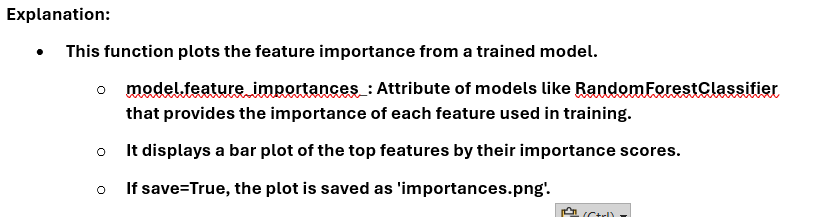

In [15]:
def val_curve_params(model, X, y, param_name, param_range, scoring="accuracy", cv=5):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

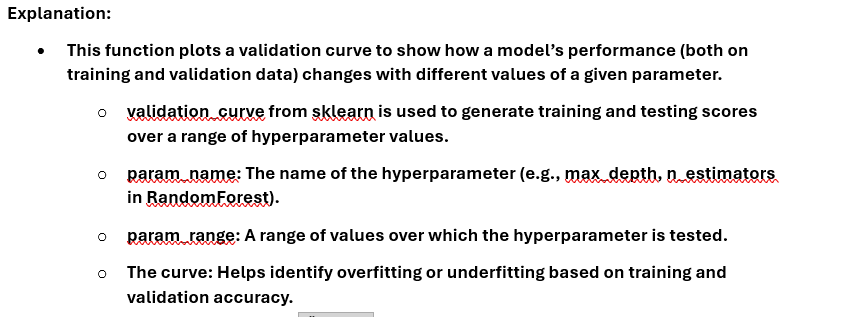

## **Data Preprocessing**

In [16]:
#Replacing outliers.
cols = [col for col in df.columns if col != "Outcome"]
for col in cols:
    replace_with_thresholds(df, col)

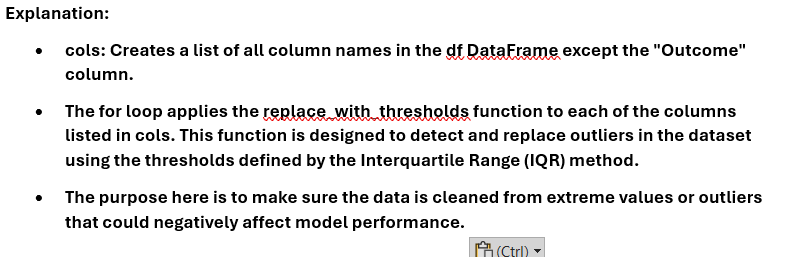

In [17]:
#Columns that cannot contain zero
problematic_cols = [col for col in df.columns if col not in ["Pregnancies",'DiabetesPedigreeFunction','Outcome']]

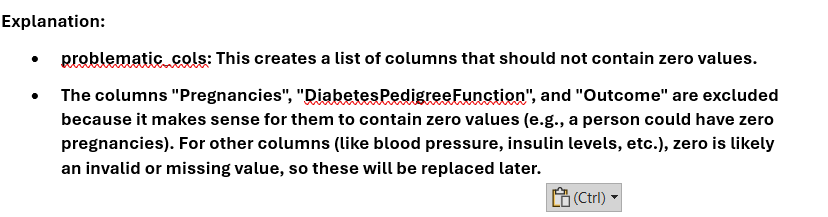

In [18]:
for col in problematic_cols:
    df[col] = df[col].replace(0, np.nan)


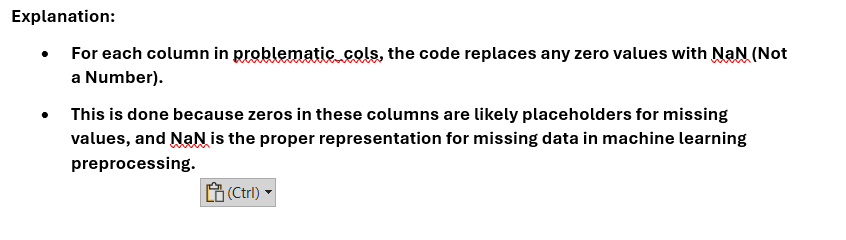

In [19]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)


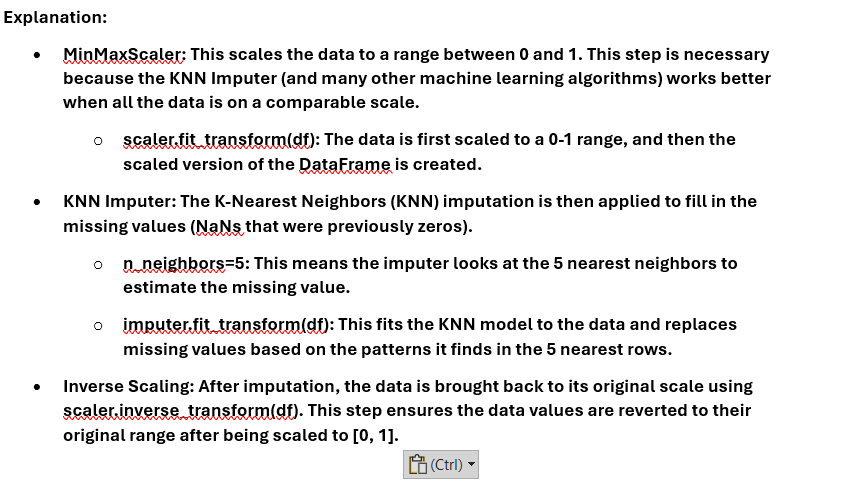

## Feature Engineering


In [20]:
df.loc[(df["Age"] <= 18 ), "NEW_AGE"] = "young"
df.loc[(df["Age"] > 18 ) & (df["Age"] <= 24), "NEW_AGE"] = "adult"
df.loc[(df["Age"] > 24 ) & (df["Age"] <= 59), "NEW_AGE"] = "mid_adult"
df.loc[(df["Age"] > 59), "NEW_AGE"] = "senior"

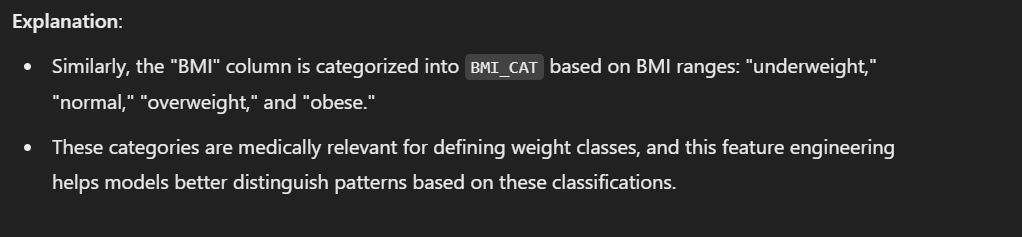

In [21]:
df.loc[(df["BMI"] < 18.5) , "BMI_CAT"] ="underweight"
df.loc[(df["BMI"] >= 18.5) & (df["BMI"] < 24.9) , "BMI_CAT"] ="normal"
df.loc[(df["BMI"] >= 24.9) & (df["BMI"] < 29.9) , "BMI_CAT"]="overweight"
df.loc[(df["BMI"] >= 29.9) , "BMI_CAT"] ="obese"



df.loc[(df["Insulin"] < 15) , "INSULIN_CAT"] ="low"
df.loc[(df["Insulin"] >= 15) & (df["Insulin"] < 166) , "INSULIN_CAT"] ="normal"
df.loc[(df["Insulin"] >= 166) , "INSULIN_CAT"] ="high"


# One Hot Encoding
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df= pd.get_dummies(df,columns= ohe_cols, drop_first=True)


X = df.drop(["Outcome"], axis=1)
y = df["Outcome"]

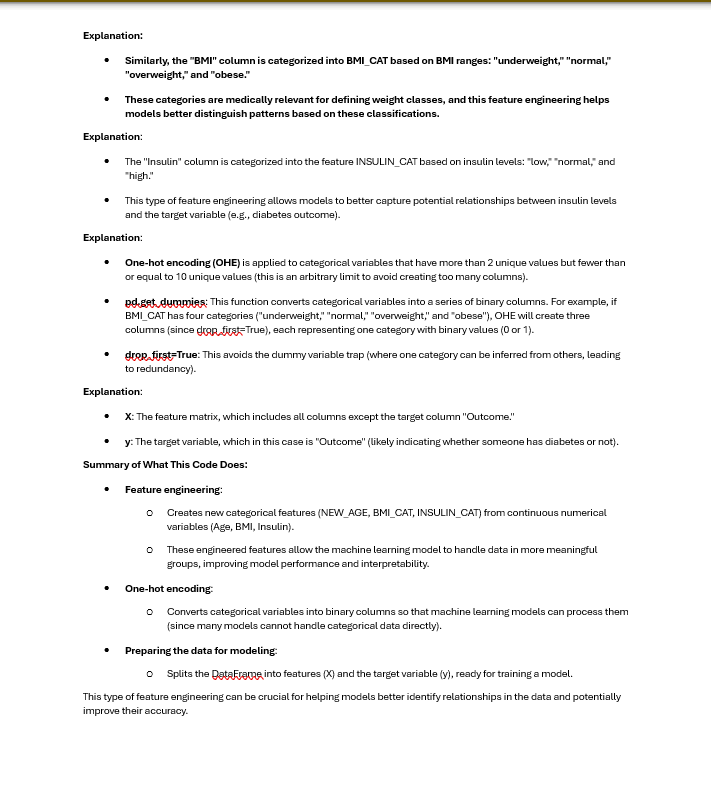

In [22]:
def feature_selecter(input_x, y, candidate_features_dict:dict, candidate_features_id:list, best_features:list, best_accuracy=0, verbose=True):
    if not candidate_features_id:
        return best_accuracy, best_features
    best_x = input_x
    best_feature= -1
    if best_accuracy == 0:
        rf_model = RandomForestClassifier(random_state=17).fit(input_x, y)

        cv_results = cross_validate(rf_model,
                                    input_x, y,
                                    cv=5,
                                    scoring="accuracy")

        best_accuracy = cv_results["test_score"].mean()

    if verbose:
       print(f"best accuracy(old) = {best_accuracy}")
       #print(candidate_features_id)

    for feature in candidate_features_id:
            X = input_x.copy(deep=True)

            # define your candidate feature here!
            if feature == 0:
                X[candidate_features_dict[feature]] = X["Insulin"]*X["Glucose"]

            elif feature == 1:
                X[candidate_features_dict[feature]] = X["Glucose"]/(X["Insulin"]+0.0001)

            elif feature == 2:
                X[candidate_features_dict[feature]] = X["Age"]*X["Pregnancies"]

            elif feature == 3:
                X[candidate_features_dict[feature]] = X["Age"]/(X["Pregnancies"]+0.0001)

            elif feature == 4:
                X[candidate_features_dict[feature]] = X["Age"]*X["Pregnancies"]*X["Glucose"]

            elif feature == 5:
                X[candidate_features_dict[feature]] = X["Glucose"]/(X["Age"]+0.0001)

            elif feature == 6:
                X[candidate_features_dict[feature]] = X["Insulin"]/(X["Age"]+0.0001)

            elif feature == 7:
                X[candidate_features_dict[feature]] = X["BMI"]*X["Pregnancies"]

            elif feature == 8:
                X[candidate_features_dict[feature]] = X["BMI"]*X["Age"]

            elif feature == 9:
                X[candidate_features_dict[feature]] =  X["BMI"]*(X["Age"])*X["Pregnancies"]

            elif feature == 10:
                X[candidate_features_dict[feature]] = X["BMI"]*(X["Glucose"])

            elif feature == 11:
                X[candidate_features_dict[feature]] = X["DiabetesPedigreeFunction"]*(X["Insulin"])

            elif feature == 12:
                X[candidate_features_dict[feature]] = X["SkinThickness"]*(X["Insulin"])

            elif feature == 13:
                X[candidate_features_dict[feature]] = X["Pregnancies"]/(X["Age"]+0.0001)

            elif feature == 14:
                X[candidate_features_dict[feature]] = X["Glucose"]+X["Insulin"]+X["SkinThickness"]

            elif feature == 15:
                X[candidate_features_dict[feature]] = X["BloodPressure"]/(X["Glucose"]+0.0001)



            rf_model = RandomForestClassifier(random_state=17).fit(X, y)

            cv_results = cross_validate(rf_model,
                                        X, y,
                                        cv=5,
                                        scoring="accuracy")

            accuracy = cv_results["test_score"].mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature
                best_x = X

    if best_feature == -1:
        return best_accuracy, best_features

    best_features.append(best_feature)
    candidate_features_id.remove(best_feature)

    if verbose:
       print(f"best accuracy(new) = {best_accuracy}")
       print(f"added feature  = {best_feature}", end = '\n\n')
       #print(best_features)

    return feature_selecter(best_x, y, candidate_features_dict, candidate_features_id, best_features, best_accuracy, verbose)

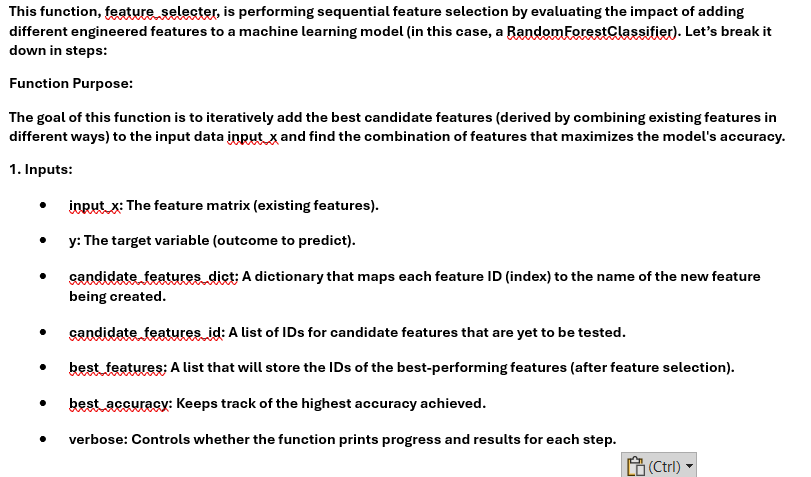

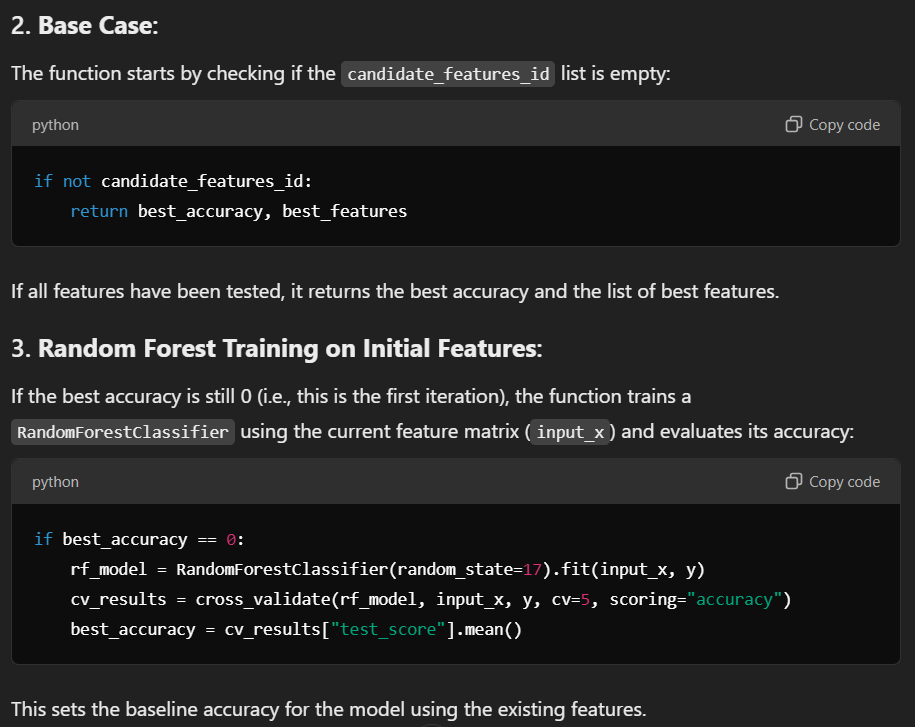

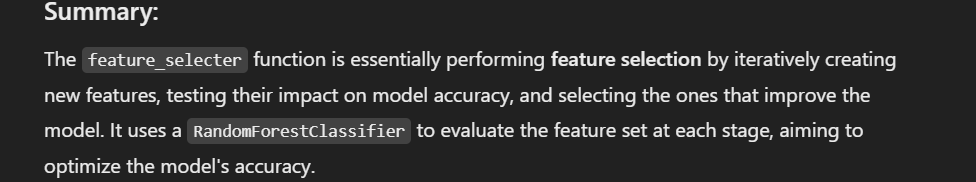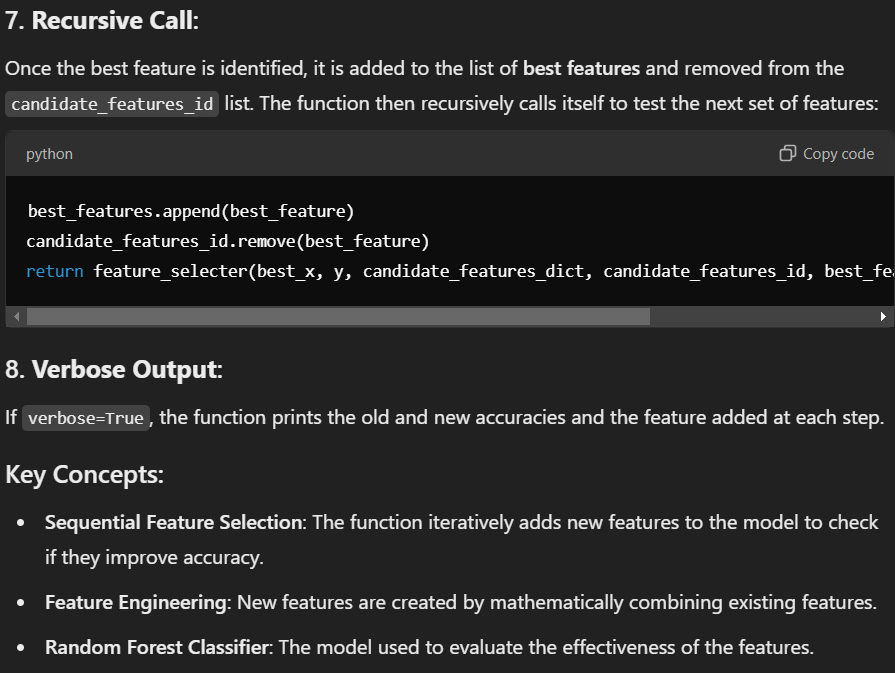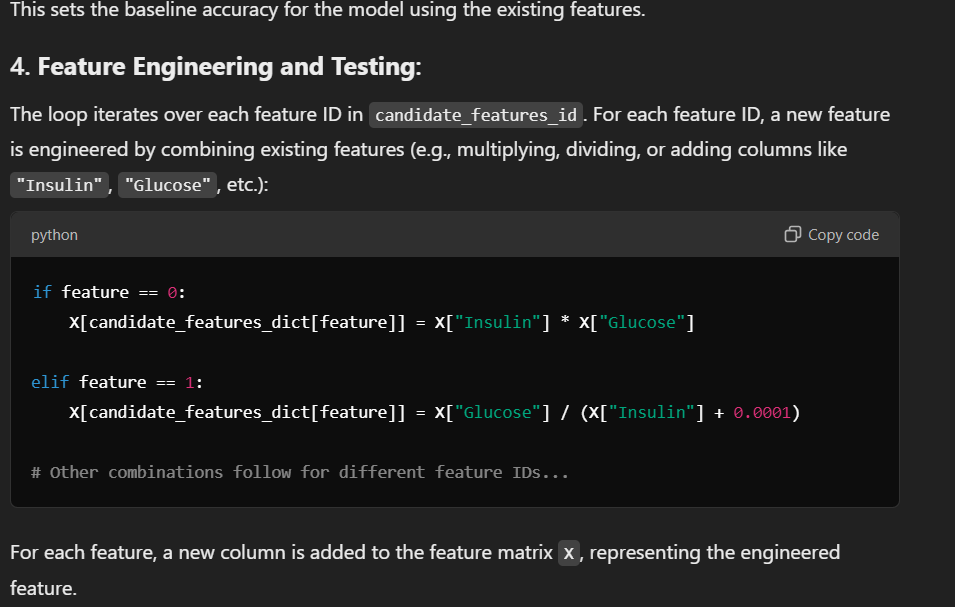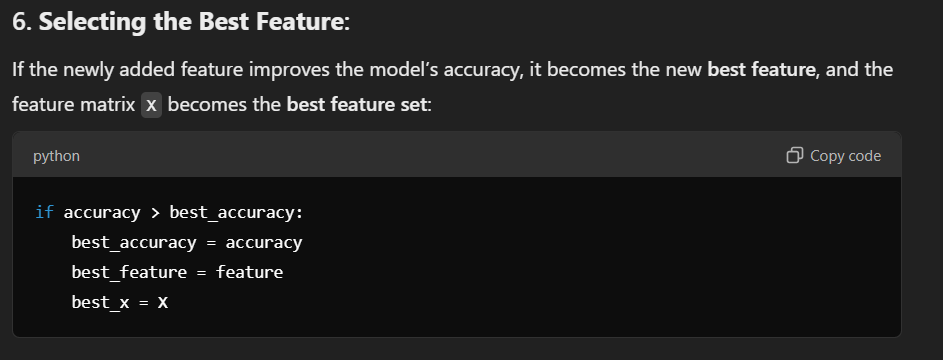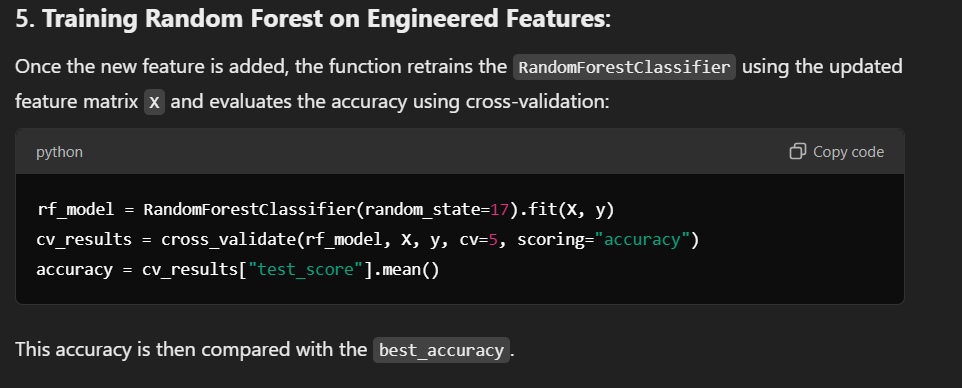

### Then, we can run feature_selecter() function,

In [23]:
candidate_features = {0:"new_glucoseXinsulin",
            1:"new_glucose/insulin",
            2:"new_ageXpreg",
            3:"new_age/preg",
            4:"new_ageXpregXglucose",
            5:"new_glucose/age",
            6:"new_insulin/age",
            7:"new_bmiXpreg",
            8:"new_bmiXage",
            9:"new_bmiXageXpreg",
            10:"new_bmiXglucose",
            11:"new_degreeXinsulin",
            12:"new_skinXinsulin",
            13:"new_preg/age",
            14:"new_glucose+insulin+skin",
            15:"new_blood/glucose"}

accuracy, new_features = feature_selecter(X,y,candidate_features, list(candidate_features.keys()), best_features=[])
'''
best accuracy(old) = 0.8086580086580086
best accuracy(new) = 0.812562600797895
added feature  = 6

best accuracy(old) = 0.812562600797895
'''




for feature in new_features:
    print(candidate_features[feature])
'''
new_insulin/age
'''



#So, it seems when we add the insulin/age feature, we obtain 81% accuracy.
#Let's see it.
X["new_insulin/age"] = X["Insulin"]/(X["Age"]+0.0001)








###############################################
# MODEL BUILDING AND EVALUATION
###############################################


#Params before GridSearchCV
rf_model = RandomForestClassifier(random_state=17)
rf_model.get_params()
'''
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}
'''

#Accuracy before GridSearchCV
cv_results = cross_validate(rf_model, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
print(f"Accuracy : {cv_results['test_accuracy'].mean()}")    # 0.8125
print(f"Precision : {cv_results['test_precision'].mean()}")  # 0.7598
print(f"Recall : {cv_results['test_recall'].mean()}")        # 0.6831
print(f"F1 Score : {cv_results['test_f1'].mean()}")          # 0.7176
print(f"ROC AUC : {cv_results['test_roc_auc'].mean()}")      # 0.8744

best accuracy(old) = 0.8086580086580086
best accuracy(new) = 0.812562600797895
added feature  = 6

best accuracy(old) = 0.812562600797895
new_insulin/age
Accuracy : 0.812562600797895
Precision : 0.7598364779874214
Recall : 0.6831586303284417
F1 Score : 0.7176950941466298
ROC AUC : 0.8744703004891685


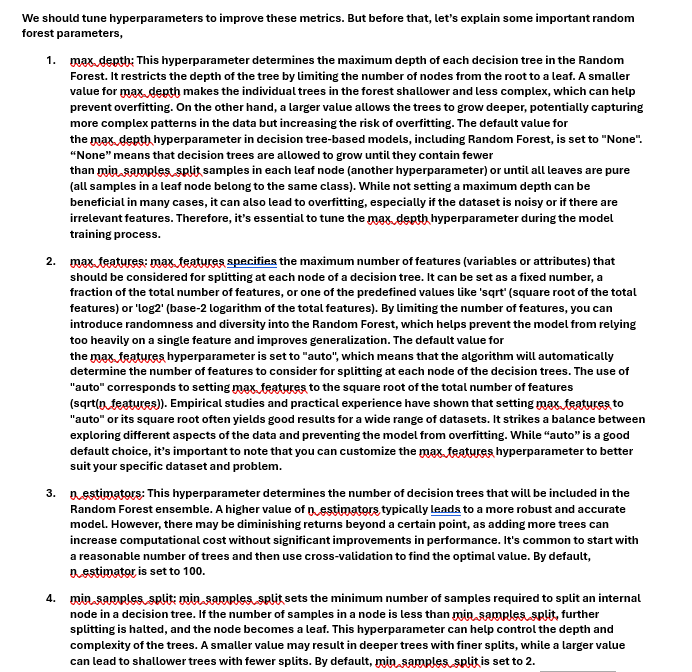

### Let’s apply GridSearchCV and find the best hyperparameters.

In [24]:
#Apply GridSearchCV
#We should also specify the default value of the parameters in the dictionary
#below, so that we do not get a worse result than the initial performance.
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}


rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X,y)

print(rf_best_grid.best_params_)
'''
Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
'''

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'max_depth': 8, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 100}


"\nFitting 5 folds for each of 180 candidates, totalling 900 fits\n{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}\n"

So, the best hyperparameter values are found as :
max_depth = ‘None’
max_feature = ‘auto’
min_samples_split = 2
n_estimators = 100
Remember, these are the default values. Therefore, hyperparameter tuning did not improve the performance. Still, let’s build a final model according to these values,

In [25]:
#Build the final model with the hyperparameter values that we have found.
rf_final = RandomForestClassifier(**rf_best_grid.best_params_, random_state=17).fit(X, y)


#5-Fold CV results for the final model
cv_results = cross_validate(rf_final, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
print(f"Accuracy : {cv_results['test_accuracy'].mean()}")     # 0.8125
print(f"Precision : {cv_results['test_precision'].mean()}")   # 0.7598
print(f"Recall : {cv_results['test_recall'].mean()}")         # 0.6831
print(f"F1 Score : {cv_results['test_f1'].mean()}")           # 0.7176
print(f"ROC AUC : {cv_results['test_roc_auc'].mean()}")       # 0.8744

Accuracy : 0.8112808759867584
Precision : 0.7504500984689664
Recall : 0.6943396226415095
F1 Score : 0.7203777025833209
ROC AUC : 0.8747798742138364


As a result, our final performance metrics are,
​ ​ ​​​ ​​ ​​​ ​ ​​ ​ ​​​ ​ ​​ ​ ​​​ ​ ​ ​ ​​​ ​​ ​​​ ​ ​​ ​ ​​​ ​ ​​ ​ ​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​​ ​​​ ​ ​​Accuracy : ​​​ ​​​ ​ 0.8125 ​​​
​ ​ ​​​ ​​ ​​​ ​ ​​ ​ ​​​ ​ ​​ ​ ​​​ ​ ​ ​ ​​​ ​​ ​​​ ​ ​​ ​ ​​​ ​ ​​ ​ ​​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​ ​​​ ​​Precision : ​​​ ​​​ ​ 0.7598 ​​​ ​​​ ​​​ ​​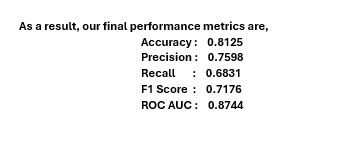


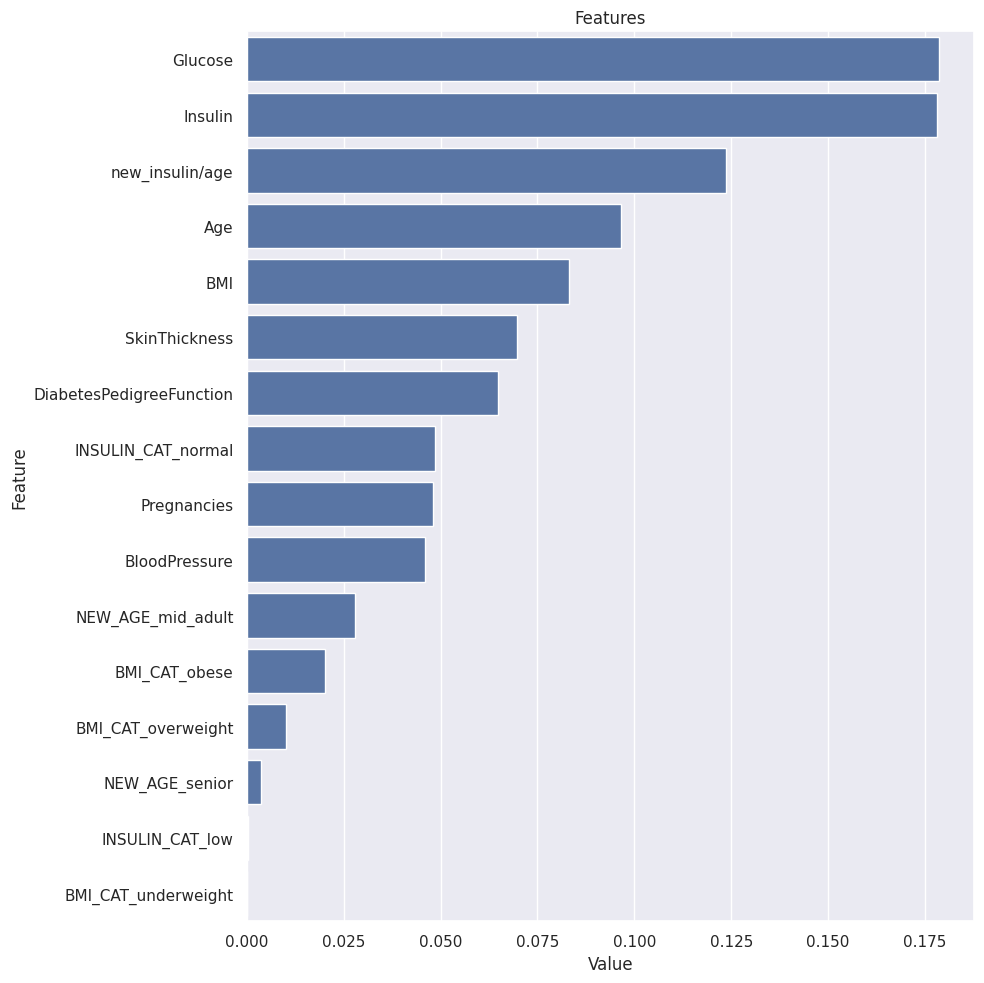

In [26]:
######################################
# FEATURE IMPORTANCE
######################################

plot_importance(rf_final, X)
#IMAGE IS BELOW (importance.png)

Looking at the graph above, we observe that the “new_insulin/age” variable that we created is very effective in the success of the model.

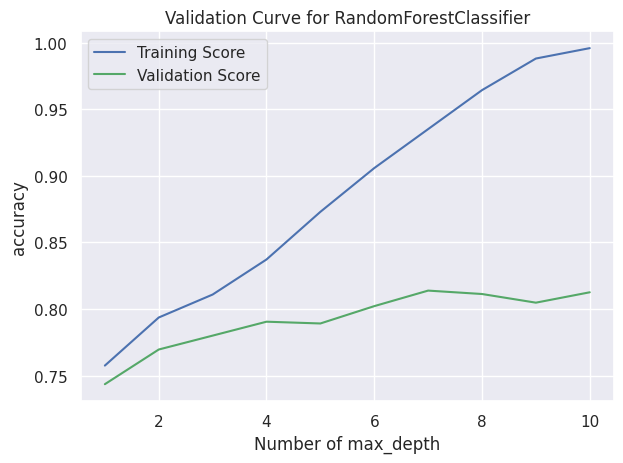

In [27]:
#######################################
# VALIDATION CURVE
#######################################

val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="accuracy")
#IMAGE IS BELOW (validation_curve.png)